# Multi-agent systems.
The general idea is to create a system based on multiple agents that can handle specific tasks rather than using one single agent that can perform multiple ones.</br>

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

In [2]:
load_dotenv(Path.cwd().parent / ".env")

True

## Create tools

In [3]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [4]:
repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "Python code to execute"]):
    """
    This function will create a python script to generate a chart
    based on user query.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to excute code: {e}"
    
    result_str = f"Succesfully excecuted:\n```python\n{code}\n```Stdout: {result}"

    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

## Graph State

In [5]:
import operator
from typing import Sequence, TypedDict
from langchain_core.messages import BaseMessage

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## Create Agents.
This system will have to agents:
1. The `researcher agent` access the web using the search tool to get information about user query.
2. The `chart agent` will use Python to cretae visuals.

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [8]:
llm = ChatOpenAI(model="gpt-4o-mini")

# -------------------------- Research agent -------------------------- #
tv_search = TavilySearchResults(max_results=5, search_depth="advanced", max_tokens=1e5)
search_tool = [tv_search]
search_tool_name = tv_search.name
research_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""
            You are a helpful AI assistant, collaborating with other assistants.
            Use the provided tools to progress towards answering the question.
            If you are unable to fully answer, that's OK,
            another assistant with different tools will help where you left off.
            Execute what you can to make progress.
            If you or any of the other assistants have the final answer or deliverable,
            prefix your response with FINAL ANSWER so the team knows to stop.

            You have access to the following tools:
            {search_tool_name}

            You should provide accurate data for use
            and source code shouldn't be the final answer
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

research_agent = (research_prompt | llm.bind_tools(search_tool))

# -------------------------- Chart agent -------------------------- #
chart_tool = [python_repl]
chart_tool_name = python_repl.name
chart_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""
            You are a helpful AI assistant, collaborating with other assistants.
            Use the provided tools to progress towards answering the question.
            If you are unable to fully answer, that's OK,
            another assistant with different tools will help where you left off.
            Execute what you can to make progress.
            If you or any of the other assistants have the final answer or deliverable,
            prefix your response with FINAL ANSWER so the team knows to stop.

            You have access to the following tools:
            {chart_tool_name}

            Run the python code to display the chart
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

chart_agent = (chart_prompt | llm.bind_tools(chart_tool))

## Define Agent nodes

In [9]:
from langchain_core.messages import ToolMessage, AIMessage
from langgraph.prebuilt import ToolNode

In [10]:
def research_agent_node(state):
    result = research_agent.invoke(state)
    # convert output to append to global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="Researcher")
        # this can be tracked as it is a stric flow
    return {"messages": [result], "sender": "Researcher"}

def chart_agent_node(state):
    result = chart_agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="chart_generator")
        # this can be tracked as it is a stric flow
    return {"messages": [result], "sender": "chart_generator"}

In [11]:
# define tool nodes
tools = [tv_search, python_repl]
tool_node = ToolNode(tools)

## Define edge logic

In [12]:
from typing import Literal

In [13]:
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # if last message is calling a tool then return call_tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # if last message is the final answet then return the end call to end graph run
        return "__end__"
    return "continue"

## Define Multi-agent graph

In [14]:
from langgraph.graph import END, StateGraph

In [15]:
# define agent graph
agent = StateGraph(AgentState)
# start defining nodes
agent.add_node("Researcher", research_agent_node)
agent.add_node("chart_generator", chart_agent_node)
agent.add_node("call_tool", tool_node)

# now add edges
agent.add_conditional_edges(
    "Researcher",
    router,
    {
        "continue": "chart_generator",
        "call_tool": "call_tool",
        "__end__": END
    }
)
agent.add_conditional_edges(
    "chart_generator",
    router,
    {
        "continue": "Researcher",
        "call_tool": "call_tool",
        "__end__": END
    }
)
agent.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator"
    }
)

agent.set_entry_point("Researcher")
agent = agent.compile()

In [16]:
from IPython.display import display, Image, Markdown

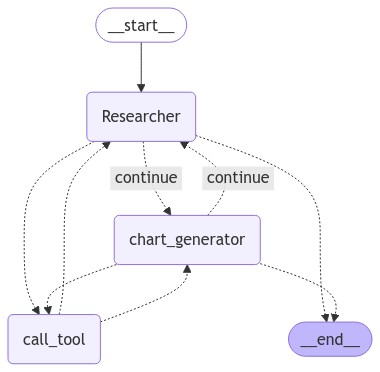

In [17]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Test the multi-agent system

Python REPL can execute arbitrary code. Use with caution.


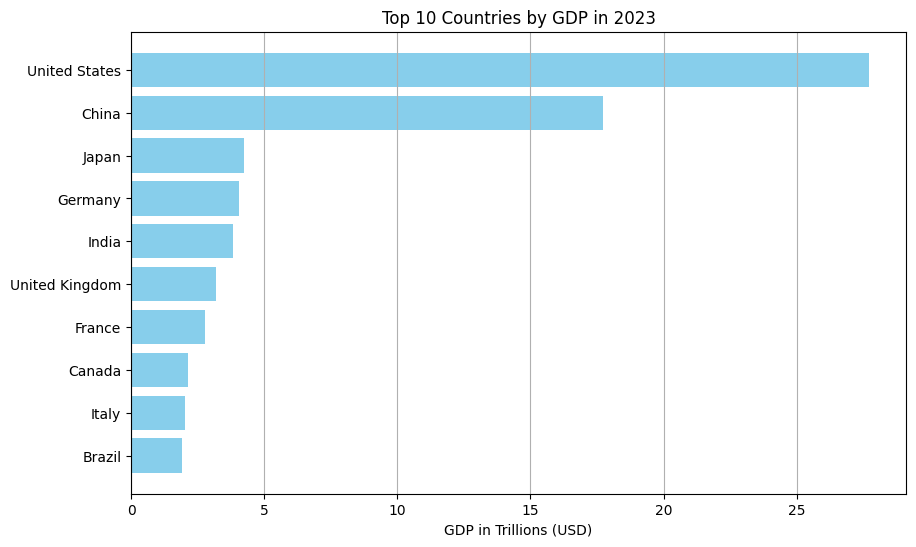

In [18]:
prompt = """Fetch the data of the top 10 countries with the highest GDP in the world.
            Then use this data and draw a bar chart.
         """

response = agent.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 150},)

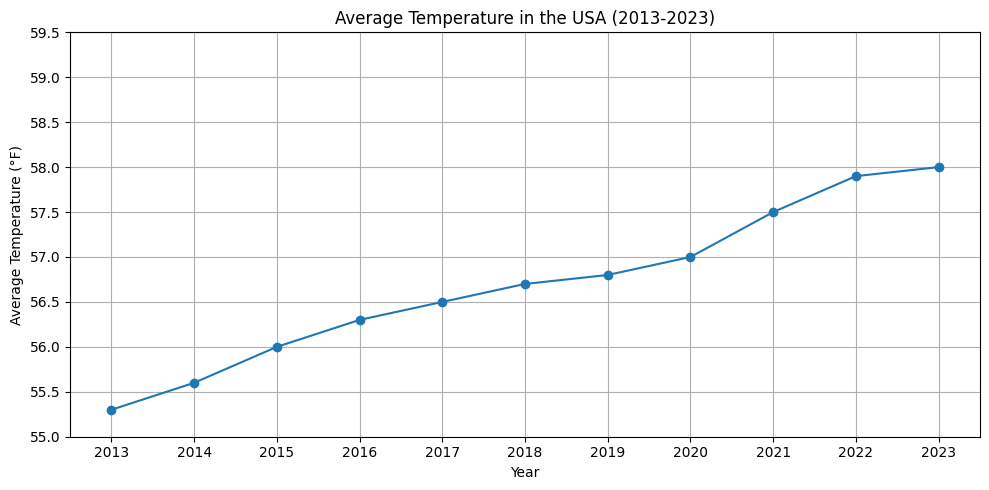

In [19]:
prompt = """Fetch the data of the average temperature of USA over the last decade.
            Then use this data and draw a line chart.
         """

response = agent.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 150},)